# Working with housing prices

### 0 - Data Exploration: What Variables have a high R statistic?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

So, first, let's figure out what the variables we are working with are! 

We can find the schema in `data/data_description.txt`

In [2]:
train_dataset = pd.read_csv('data/train.csv')
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
train_dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


So, we have 80 variables, excluding the id values.  Clearly, SalePrice (presumably USD?) is in fact our target for any predictive model, and assumingly has dependence to some degree to a number of variables in this dataset.   Let's take a look at one integer variable, and view the relationship between the selling price and our selected variable.

### 0.1 Computing R statistic Methodology

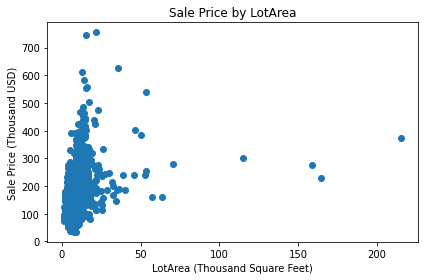

In [4]:
x = train_dataset['LotArea']
y = train_dataset['SalePrice']

plt.scatter([x_area/1000 for x_area in x], [y_price/1000 for y_price in y])
plt.xlabel("LotArea (Thousand Square Feet)")
plt.ylabel("Sale Price (Thousand USD)")
plt.yticks()
plt.title('Sale Price by LotArea')
plt.tight_layout()
plt.show()

So it is apparent that outliers will be present in this dataset, however, I am resisting the urge to outright exclude outliers in this, as this process will be quite tedious to do in all 80 variables in the dataset. So, we can calculate the R statistic, without reducing any outliers given the following:

<h1><center>$ \text{corr}(X, Y) = \frac{\sum_i (x_i - \overline{x})(y_i - \overline{y})}{\sqrt{\sum_i(x_i-\overline{x})^2 \cdot \sum_i(y_i - \overline{y})^2}} $</center></h1>

In [5]:
lotArea_mean = np.mean(x)
salePrice_mean = np.mean(y)
lotArea_var = [value - lotArea_mean for value in x]
salePrice_var = [value - salePrice_mean for value in y]
a = np.dot(lotArea_var, salePrice_var)
b = (np.dot(lotArea_var, lotArea_var) * np.dot(salePrice_var, salePrice_var))**0.5
r = a/b
print(f'{round(r, 3)} is the correlation of lotArea and salePrice.')

0.264 is the correlation of lotArea and salePrice.


Of course, this is just one variable.  We need to do a couple of things in order to get the R statistics of every single variable.  Mainly, we need to convert the values of the dataset, mapping non-numerical values to discrete numerical values.  Referring to the info of the values, at the top of this document, we can observe there are 43 non-numerical values.  Of those 43 values, it appears that each value can only be one possible representation, meaning mapping a string value to a numerical value is in fact possible.

Some variables have 2nd values, for example, `Exterior1st` and `Exterior2nd`. The existance of the second implies the first, and an Na result of the second implies only one material, but an Na result of the first will imply it just wasn't recorded.

For my sake, we'll start by defining a function that takes in two arrays of numbers, and can compute the R statistic, using the same math above.

In [6]:
def compute_r(var, dependent_var=None): # default dependent_var is SalePrice in this project
    dependent_var = train_dataset['SalePrice'] if dependent_var is None else dependent_var
    var_mean = np.mean(var)
    dependent_var_mean = np.mean(dependent_var)
    var_variation = [x_i - var_mean for x_i in var]
    target_variation = [y_i - dependent_var_mean for y_i in dependent_var]
    return (np.dot(var_variation, target_variation)) / (np.dot(var_variation, var_variation) * np.dot(target_variation, target_variation))**0.5

In [7]:
print(compute_r(train_dataset['LotArea']))
print(compute_r(train_dataset['OverallQual']))
print(compute_r(train_dataset['OverallCond']))
print(compute_r(train_dataset['OverallCond'], train_dataset['OverallQual']))
print(compute_r(train_dataset['OverallCond'], train_dataset['OverallCond']))

0.2638433538714057
0.7909816005838051
-0.07785589404867803
-0.09193234263907182
1.0


As we can see, this function is really easy to use, and will enable us to quickly compute R values of each variable in our system.  

### 0.2 Mapping string values to discrete numerical values

So, I'm not attempting to be incredibly competitive in this statistical model, (at least, not for now!), rather, I'm doing this 

In [8]:
train_dataset['MasVnrType']

0       BrkFace
1          None
2       BrkFace
3          None
4       BrkFace
         ...   
1455       None
1456      Stone
1457       None
1458       None
1459       None
Name: MasVnrType, Length: 1460, dtype: object

### 0.3 Difficulties in mapping string values: ordering

As I am imagining a system, there is a complication.  This currently is a note, but could end up being a room for improvement.  As we take some values, and map them to integers, we face the risk of ordering them incorrectly.  Thus, we should only convert values that have a clear linear quality rating.

### 0.4 - integer R values

Of the integer values, let's analyze which metrics are the most related in this dataset.

In [9]:
correlations = {}
for value in train_dataset:
    if train_dataset[value].dtype != object:
        correlations[value] = compute_r(train_dataset[value])

meaningful_metrics = list(filter(lambda x : abs(correlations[x]) > 0.5 and abs(correlations[x]) != 1, correlations))
values_of_meaningful_metrics = list(map(lambda x : correlations[x], meaningful_metrics))
[print(f'Corr({metric}, SalePrice) \t = {round(values_of_meaningful_metrics[index], 2)}') for index, metric in enumerate(meaningful_metrics)]
meaningful_metrics

Corr(OverallQual, SalePrice) 	 = 0.79
Corr(YearBuilt, SalePrice) 	 = 0.52
Corr(YearRemodAdd, SalePrice) 	 = 0.51
Corr(TotalBsmtSF, SalePrice) 	 = 0.61
Corr(1stFlrSF, SalePrice) 	 = 0.61
Corr(GrLivArea, SalePrice) 	 = 0.71
Corr(FullBath, SalePrice) 	 = 0.56
Corr(TotRmsAbvGrd, SalePrice) 	 = 0.53
Corr(GarageCars, SalePrice) 	 = 0.64
Corr(GarageArea, SalePrice) 	 = 0.62


['OverallQual',
 'YearBuilt',
 'YearRemodAdd',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea']

### 0.inf Some other important metrics:

In [10]:
average_sale_price = np.mean(train_dataset['SalePrice'])
print(round(average_sale_price, 2))

integer_subset = train_dataset[meaningful_metrics]
integer_subset

180921.2


,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageCars,GarageArea
0,7,2003,2003,856,856,1710,2,8,2,548
1,6,1976,1976,1262,1262,1262,2,6,2,460
2,7,2001,2002,920,920,1786,2,6,2,608
3,7,1915,1970,756,961,1717,1,7,3,642
4,8,2000,2000,1145,1145,2198,2,9,3,836
...,...,...,...,...,...,...,...,...,...,...
1455,6,1999,2000,953,953,1647,2,7,2,460
1456,6,1978,1988,1542,2073,2073,2,7,2,500
1457,7,1941,2006,1152,1188,2340,2,9,1,252
1458,5,1950,1996,1078,1078,1078,1,5,1,240


### 1 - Beginning to create some predictive models

For now, we will only go with integer values of models, because this is a personal project, and if I want to improve it down the line, I can do whatever I want

Intercept: 
 -1186193.766666138
Coefficients: 
 [ 1.96045898e+04  2.68240707e+02  2.96481161e+02  1.98650991e+01
  1.41737355e+01  5.12971178e+01 -6.79087146e+03  3.31050771e+01
  1.04179010e+04  1.49475334e+01]


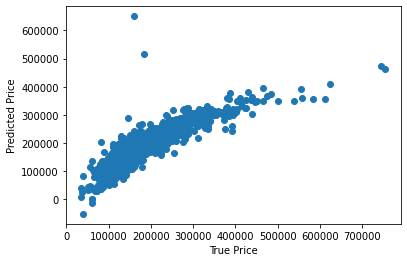

correlation of regression model prediction and trained model: 0.8795981129341572


In [11]:
from sklearn import linear_model
from sklearn.metrics import log_loss
first_regr = linear_model.LinearRegression()
first_regr.fit(integer_subset, train_dataset['SalePrice'])
print('Intercept: \n', first_regr.intercept_)
print('Coefficients: \n', first_regr.coef_)

predicted_housing_prices = first_regr.predict(integer_subset)

plt.scatter(train_dataset['SalePrice'], predicted_housing_prices)
plt.ylabel('Predicted Price')
plt.xlabel('True Price')
plt.show()
print(f'correlation of regression model prediction and trained model: {compute_r(predicted_housing_prices)}')

Compare this with if we used every single value:

Intercept: 
 494629.77780977346
Coefficients: 
 [-1.57033613e+00 -1.62043583e+02  3.93529968e-01  1.78673614e+04
  4.43834247e+03  3.46599894e+02  1.36095592e+02  1.18143776e+01
 -2.77238271e+00  7.81550249e-01  9.82354511e+00  1.91434191e+01
  1.90537801e+01 -6.60364521e+00  3.15935539e+01  8.55978466e+03
  2.41313501e+03  3.60827325e+03 -1.28944249e+03 -1.05114341e+04
 -1.31089080e+04  5.16033233e+03  3.56475962e+03  1.06671300e+04
  1.46195515e+00  2.61687577e+01 -5.62631378e+00  8.67404295e+00
  1.76644445e+01  5.78098509e+01 -4.15085658e+01 -8.98520043e-01
 -1.07892813e+02 -7.52141893e+02]


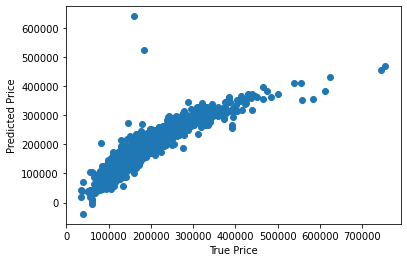

correlation of regression model prediction and trained model: 0.8994289869674716


In [12]:
# [print(correlations[x], np.isnan(correlations[x])) for x in correlations]

non_numbers = list(filter(lambda x : not np.isnan(correlations[x]) and correlations[x] != 1, correlations))
all_vars = train_dataset[non_numbers]
all_vars

regr = linear_model.LinearRegression()
regr.fit(all_vars, train_dataset['SalePrice'])
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

predicted_housing_prices = regr.predict(all_vars)

plt.scatter(train_dataset['SalePrice'], predicted_housing_prices)
plt.ylabel('Predicted Price')
plt.xlabel('True Price')
plt.show()
print(f'correlation of regression model prediction and trained model: {compute_r(predicted_housing_prices)}')

So, while my model has less correlation than using linear regression on the second model, I believe that I may be at an advantage when it comes time to test, as the problem of overfitting may apply and negatively affect accounting for all variables.  Let's submit our model!

0       1461
1       1462
2       1463
3       1464
4       1465
        ... 
1454    2915
1455    2916
1456    2917
1457    2918
1458    2919
Name: Id, Length: 1459, dtype: int64


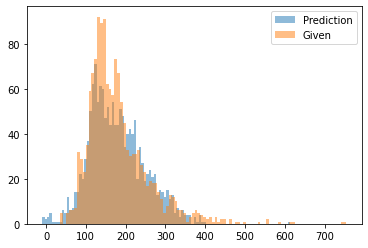

In [17]:
test_dataset = pd.read_csv('data/test.csv')
ids = test_dataset['Id']
print(ids)
test_dataset = test_dataset[meaningful_metrics]
for column in test_dataset:
    for index, value in enumerate(test_dataset[column]):
        if np.isnan(value):
            test_dataset[column][index] = 0

pred = pd.Series(first_regr.predict(test_dataset))
plt.hist([price/1000 for price in pred], bins=100, alpha=0.5, label='Prediction')
plt.hist([price/1000 for price in train_dataset['SalePrice']], bins=100, alpha=0.5, label='Given')
plt.legend()
plt.show()

pd.DataFrame({"Id": ids, "SalePrice":pred}).to_csv('prediction_submission.csv', index=False)


This model, did quite bad, however, I'm still decently proud, since it used techniques that I completely understand, from classes I have taken at university.  I was in the bottom 3% of submissions, however, and I will probably keep improving on this model.  Stay tuned